<span style="font-size:xxx-large;">Image segmentation</span>

<span style="font-size:xxx-large;"> Lab report</span>

<span style="font-size:xx-large;">Mateusz Górczany</span>

In [626]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.compat.v1 as v1
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from augmentators import randomHueSaturationValue, randomHorizontalFlip, randomShiftScaleRotate
from u_net import get_unet_128
import glob
import keras.backend as K

In [2]:
epochs = 200
epochs = 50
batch_size = 1 # best results 
input_size, model = get_unet_128()


In [3]:
train_img_path_template = 'input/train/{}.jpg'
train_img_mask_path_template = 'input/train/segmentation/{}.png'

train_filenames = glob.glob("input/train/*.jpg")
train_filenames = [filename.replace('\\','/').replace('.jpg', '') for filename in train_filenames]
train_filenames = [filename.split('/')[-1] for filename in train_filenames]


In [4]:
train_split, valid_split = train_test_split(train_filenames, test_size=0.10, random_state=42)

print('Training on {} samples'.format(len(train_split)))
print('Validating on {} samples'.format(len(valid_split)))


Training on 15 samples
Validating on 2 samples


In [5]:
def train_generator():
    while True:
        train_split, valid_split = train_test_split(train_filenames, test_size=0.10, random_state=42)

        for start in range(0, len(train_split), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(train_split))
            ids_train_batch = train_split[start:end]
            for id in ids_train_batch:
                img  = cv2.imread(train_img_path_template.format(id))
                img  = cv2.resize(img, (input_size, input_size))
                mask = cv2.imread(train_img_mask_path_template.format(id), cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, (input_size, input_size))
                img = randomHueSaturationValue(img,
                                               hue_shift_limit=(-50, 50),
                                               sat_shift_limit=(-5, 5),
                                               val_shift_limit=(-15, 15))
                img, mask = randomShiftScaleRotate(img, mask,
                                                   shift_limit=(-0.25, 0.25),
                                                   scale_limit=(-0.3, 0.3),
                                                   rotate_limit=(-10, 10))
                img, mask = randomHorizontalFlip(img, mask)
                mask = np.expand_dims(mask, axis=2)
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch

In [6]:
def valid_generator():
    while True:
        train_split, valid_split = train_test_split(train_filenames, test_size=0.10, random_state=42)
        for start in range(0, len(valid_split), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(valid_split))
            ids_valid_batch = valid_split[start:end]
            for id in ids_valid_batch:
                img  = cv2.imread(train_img_path_template.format(id))
                img  = cv2.resize(img, (input_size, input_size))
                mask = cv2.imread(train_img_mask_path_template.format(id), cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, (input_size, input_size))
                mask = np.expand_dims(mask, axis=2)
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch

In [7]:
callbacks = [
#        EarlyStopping(monitor='val_dice_loss',
#                           patience=8,
#                           verbose=1,
#                           min_delta=1e-4,
#                           mode='max'),
             ReduceLROnPlateau(monitor='val_dice_loss',
                               factor=0.5,
                               patience=4,
                               verbose=1,
                               epsilon=1e-5,
                               mode='max'),
             ModelCheckpoint(monitor='val_dice_loss',
                             filepath='weights/best_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max'),
             TensorBoard(log_dir='logs')]

In [9]:
history = model.fit_generator(generator=train_generator(),
                    # steps = length of training set/ batch size
                    steps_per_epoch=np.ceil(float(len(train_split)) / float(batch_size)),
                    epochs=epochs,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_generator(),
                    validation_steps=np.ceil(float(len(valid_split)) / float(batch_size)))


Epoch 1/50
15/15 - 10s - loss: 0.6814 - dice_loss: 0.5871 - val_loss: 1.3431 - val_dice_loss: 0.2301
Epoch 2/50
15/15 - 9s - loss: 0.5517 - dice_loss: 0.6584 - val_loss: 1.3023 - val_dice_loss: 0.2225
Epoch 3/50
15/15 - 9s - loss: 0.4823 - dice_loss: 0.7048 - val_loss: 1.3596 - val_dice_loss: 0.3596
Epoch 4/50
15/15 - 9s - loss: 0.3316 - dice_loss: 0.7868 - val_loss: 1.3569 - val_dice_loss: 0.1331
Epoch 5/50
15/15 - 8s - loss: 0.6030 - dice_loss: 0.6726 - val_loss: 1.3021 - val_dice_loss: 0.1532
Epoch 6/50
15/15 - 11s - loss: 0.3677 - dice_loss: 0.7647 - val_loss: 0.8537 - val_dice_loss: 0.4599
Epoch 7/50
15/15 - 12s - loss: 0.3146 - dice_loss: 0.8078 - val_loss: 1.4627 - val_dice_loss: 0.0823
Epoch 8/50
15/15 - 9s - loss: 0.2460 - dice_loss: 0.8469 - val_loss: 1.4677 - val_dice_loss: 0.0803
Epoch 9/50
15/15 - 9s - loss: 0.4682 - dice_loss: 0.7579 - val_loss: 1.5629 - val_dice_loss: 0.1077
Epoch 10/50

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
15/1

# Analysis

In [20]:
df = pd.DataFrame(history.history)

In [24]:
df.index += 1

In [615]:
df.index.name = "epoch"

## Losses table

In [587]:
df

,loss,dice_loss,val_loss,val_dice_loss,lr
epoch,,,,,
1,0.681400,0.587090,1.343143,0.230082,0.001000
2,0.551691,0.658399,1.302299,0.222471,0.001000
3,0.482309,0.704761,1.359647,0.359552,0.001000
4,0.331566,0.786781,1.356885,0.133133,0.001000
5,0.603037,0.672570,1.302074,0.153239,0.001000
6,0.367677,0.764727,0.853707,0.459854,0.001000
7,0.314575,0.807828,1.462730,0.082252,0.001000
8,0.246049,0.846873,1.467706,0.080272,0.001000
9,0.468191,0.757921,1.562902,0.107736,0.001000


In [616]:
import matplotlib.pyplot as plt

## Losses plot

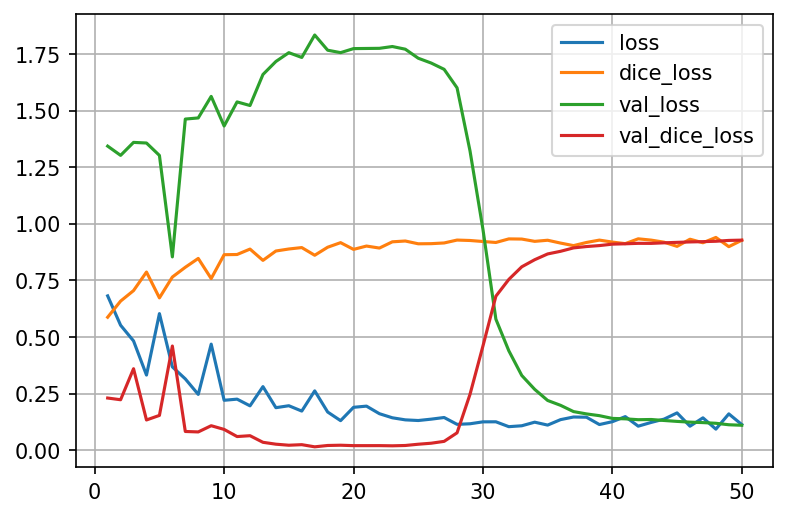

In [589]:
plt.figure(dpi=150)
plt.plot(df[df.columns[:-1]])
plt.legend(list(df.columns[:-1]))
plt.grid()

## Image comparison and dice loss

In [198]:
def filenames():
    test_filenames = glob.glob("input/train/segmentation/*.png")
    test_filenames = [filename.replace('\\','/').replace('.png', '') for filename in test_filenames]
    test_filenames = [filename.split('/')[-1] for filename in test_filenames]
    
    return test_filenames

In [590]:
def load_img(filename):
    validate = cv2.imread("input/train/segmentation/{}.png".format(filename))
    to_pred = cv2.imread("input/test/{}.jpg".format(filename))
    
    return to_pred, validate

In [607]:
def prepare_to_dice_loss(pred, test):
    orig_width = 240
    orig_height = 320
    pred = np.array(cv2.resize(np.squeeze(pred), (orig_width, orig_height)).astype(np.float32))
    return pred, np.array(cv2.cvtColor(test, cv2.COLOR_BGR2GRAY) / 255.).astype(np.float32)

In [608]:
def prepare_to_pred(image, input_size):
    image = cv2.resize(image, input_size)
    image = np.array(image, np.float32) / 255
    image = np.expand_dims(image, axis=0)
    
    return image

In [609]:
def original_size(image):
    orig_width = 240
    orig_height = 320
    threshold = 0.5
    image = (np.array(np.resize(np.squeeze(image), (orig_width, orig_height)) > 0.5) * 255).astype(np.uint8)
    
    return image

In [610]:
def to_255(image):
    return (np.array(image > 0.5)*255).astype(np.uint8)

In [611]:
def predict_image(image, input_size):
    image = prepare_to_pred(image, input_size)
    pred = model.predict(image)
    return pred 

In [612]:
def dice_loss2(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (tf.constant(2.0) * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)



In [624]:
def plot_images(image_names, model, input_size):
    fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(32,32), dpi=150)
    for index in range(10):
        img_to_pred, validate = load_img(image_names[index])
        pred = predict_image(img_to_pred, input_size)
        pred, validate2 = prepare_to_dice_loss(pred, validate)
        loss = dice_loss2(pred, validate2).numpy()
        
        ax[index, 0].imshow(validate)
        ax[index, 0].set_title(f"Correct")
        ax[index, 1].imshow(to_255(pred))
        ax[index, 1].set_title(f"Predicted, dice loss: {loss}")
        
    fig.tight_layout()
    fig.tight_layout()
    plt.show()

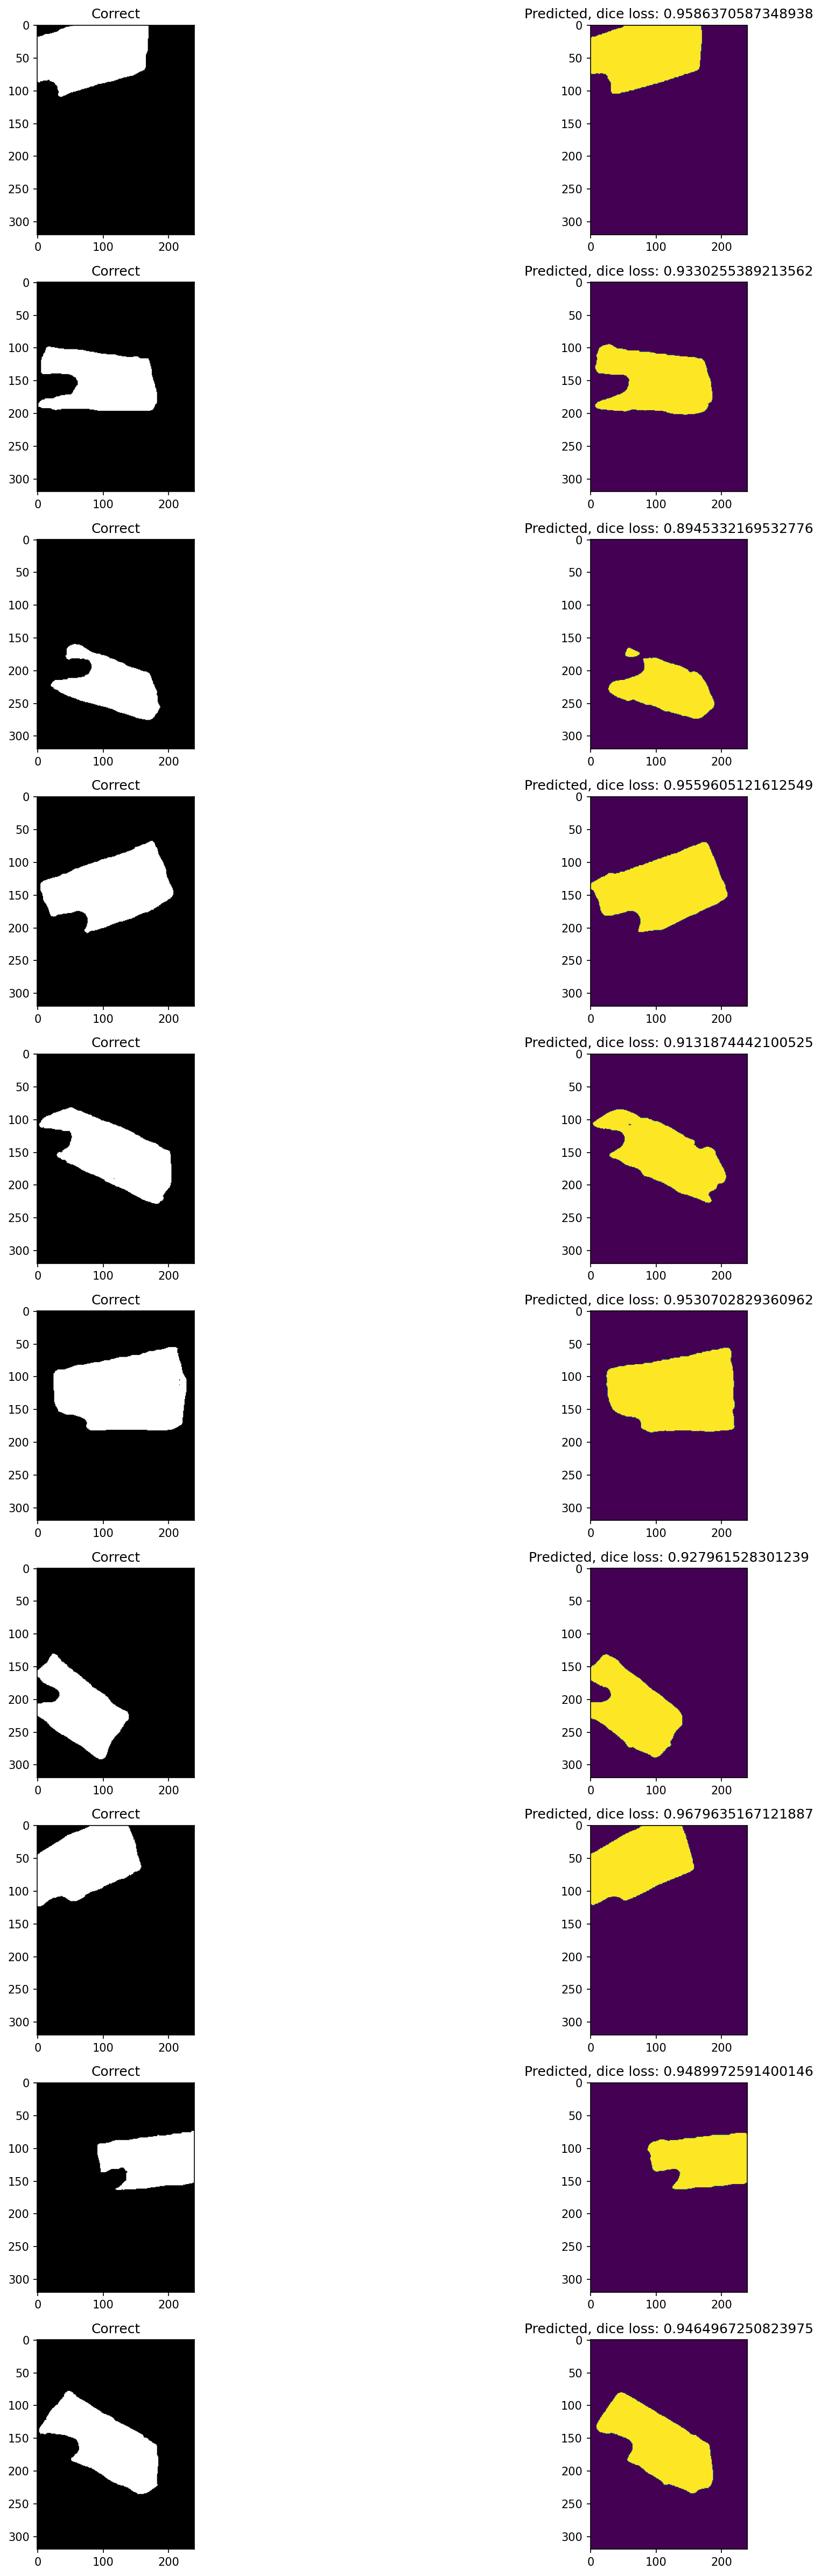

In [625]:
plot_images(filenames(), model, (input_size, input_size))